In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import seaborn as sns

from mat4py import loadmat

from tqdm import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

from pyriemann.estimation import Covariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Для кросс-корреляции
from scipy.signal import correlate

from utils import dataset
from utils import correlation_analysis
from utils import save_object
from utils import load_object

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Получаем набор данных и проводим аугментацию

### Набор данных Left/Right Hand MI (motor imagery)

Описание данных:

The MATLAB structure of the EEG (1st to 64th channel) and EMG (65th to 68th channel) data ("*.mat") for each subject is shown below:

rest: resting state with eyes-open condition

noise:

- eye blinking, 5 seconds × 2

- eyeball movement up/down, 5 seconds × 2

- eyeball movement left/right, 5 seconds × 2

- jaw clenching, 5 seconds × 2

- head movement left/right, 5 seconds × 2

imagery_left: 100 or 120 trials of left hand MI

imagery_right: 100 or 120 trials of right hand MI

n_imagery_trials: 100 or 120 trials for each MI class (число попыток представить левую/правую руку)

imagery_event: value “1” represents onset for each MI trial

movement_left: 20 trials of real left hand movement

movement_right: 20 trials of real right hand movement

n_movement_trials: 20 trials for each real hand movement class

movement_event: value “1” represents onset for each movement trial

frame: temporal range of a trial in milliseconds

srate: sampling rate (частота в Гц)

senloc: 3D sensor locations

psenloc: sensor location projected to unit sphere

subject: subject's two-digit ID - “s#”

comment: comments for the subject

bad_trial_indices

- bad trials determined by voltage magnitude

- bad trials correlated with EMG activity

Расположение электродов объекта s03

In [9]:
data_s03 = load_object('dataset_hand_MI_bin/s03.pkl')
loc = np.array(data_s03['eeg']['senloc'])

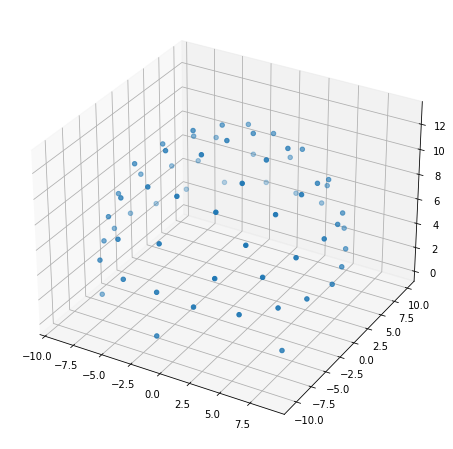

In [12]:
x = loc[:, 0]
y = loc[:, 1]
z = loc[:, 2]

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

plt.show()

То есть если проанализировать моменты попыток, то попытка делается каждые 3584 отсчета. Поэтому для данных с 100 попытками берем размер окна 3584, чтобы туда наверняка попадала 1 попытка.

### Введем обозначение классов
- класс 0 это MI left hand
- класс 1 это MI right hand

# TODO AUG

In [13]:
!pip install tsaug

In [ ]:
class dataset():
    def __init__(self):
        pass

    def get_sub_data(self, file_name):
        data = load_object(file_name)
        # Получение временных рядов для каждого класса
        ts_0 = np.array(data['eeg']['imagery_left'])
        ts_1 = np.array(data['eeg']['imagery_right'])
        # Оставляем только сигналы EEG
        ts_0 = ts_0[:64]
        ts_1 = ts_1[:64]
        return ts_0, ts_1 
    
    # Получаем корреляционные матрицы и метки классов после аугментации временных рядов
    def get_augmented_Covariances(self, window_size = 3584):
        X_Cov = []
        y = []
        n_sub = []
        for i in tqdm(range(52)):
            sub_number = 's0'+str(i+1)+'.pkl' if len(str(i+1))==1 else 's'+str(i+1)+'.pkl'
            file_name = 'dataset_hand_MI_bin/' + sub_number
            ts_0, ts_1 = self.get_sub_data(file_name)
            ts_0 = np.array([ts_0[:, i:i+window_size] for i in range(0, ts_0.shape[1], window_size)])
            ts_1 = np.array([ts_1[:, i:i+window_size] for i in range(0, ts_1.shape[1], window_size)])
            for part_ts_0, part_ts_1 in zip(ts_0, ts_1):
                X_Cov.append(Covariances().fit_transform(np.expand_dims(part_ts_0, axis=0))[0])
                X_Cov.append(Covariances().fit_transform(np.expand_dims(part_ts_1, axis=0))[0])
                y.append(0)
                y.append(1)
                n_sub.append(i)
                n_sub.append(i)
        return np.array(X_Cov), np.array(y), np.array(n_sub)

In [10]:
data = dataset()
X_Cov, y, n_sub = data.get_augmented_Covariances()

# Сохранение
#np.save('dataset_hand_MI_bin/X_cov.npy', X_Cov)
#np.save('dataset_hand_MI_bin/y.npy', y)
#np.save('dataset_hand_MI_bin/n_sub', n_sub)

100%|██████████| 52/52 [07:39<00:00,  8.84s/it]


In [175]:
X_Cov = np.load('dataset_hand_MI_bin/Preprocessed_data_3584/X_cov.npy')
y = np.load('dataset_hand_MI_bin/Preprocessed_data_3584/y.npy')

In [176]:
X_Cov.shape

(10520, 64, 64)

### Перейдем в касательное пространство и воспользуемся классическими методами

In [177]:
X_Cov_train, X_Cov_test, y_train, y_test = train_test_split(X_Cov, y, test_size=0.2, random_state=42, stratify=y)

### 1) LogisticRegression

In [91]:
ts = TangentSpace()
logreg = LogisticRegression(C = 1)
clf = make_pipeline(ts,logreg)

clf.fit(X_Cov_train, y_train)

y_pred_train = clf.predict(X_Cov_train)
y_pred = clf.predict(X_Cov_test)

In [92]:
print(f'Accuracy on train {round(accuracy_score(y_train, y_pred_train), 3)}, f1-score on train {round(f1_score(y_train, y_pred_train), 3)}')
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on train 0.774, f1-score on train 0.773
Accuracy on test 0.566, f1-score on test 0.565


Переобучается сильно

### 2) SVM

In [93]:
ts = TangentSpace()
svc = SVC(kernel='rbf', C=1)
clf = make_pipeline(ts,svc)

clf.fit(X_Cov_train, y_train)

y_pred_train = clf.predict(X_Cov_train)
y_pred = clf.predict(X_Cov_test)

In [94]:
print(f'Accuracy on train {round(accuracy_score(y_train, y_pred_train), 3)}, f1-score on train {round(f1_score(y_train, y_pred_train), 3)}')
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on train 0.949, f1-score on train 0.948
Accuracy on test 0.533, f1-score on test 0.519


Модель ужасно переобучается, попробуем добавить PCA

### 3) PCA + LogisticRegression

In [95]:
ts = TangentSpace()
pca = PCA(1500)
logreg = LogisticRegression(C = 1)
clf = make_pipeline(ts,pca,logreg)

clf.fit(X_Cov_train, y_train)

y_pred_train = clf.predict(X_Cov_train)
y_pred = clf.predict(X_Cov_test)

In [96]:
print(f'Accuracy on train {round(accuracy_score(y_train, y_pred_train), 3)}, f1-score on train {round(f1_score(y_train, y_pred_train), 3)}')
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on train 0.73, f1-score on train 0.73
Accuracy on test 0.56, f1-score on test 0.559


### 4) Добавим фильтрацию XdawnCovariances

In [178]:
# SVM
covest = XdawnCovariances()
ts = TangentSpace(metric='riemann')
svc = SVC(kernel='rbf')

clf.fit(X_Cov_train, y_train)

y_pred_train = clf.predict(X_Cov_train)
y_pred = clf.predict(X_Cov_test)

In [179]:
print(f'Accuracy on train {round(accuracy_score(y_train, y_pred_train), 3)}, f1-score on train {round(f1_score(y_train, y_pred_train), 3)}')
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on train 0.73, f1-score on train 0.73
Accuracy on test 0.562, f1-score on test 0.564


---

## Корреляционный анализ

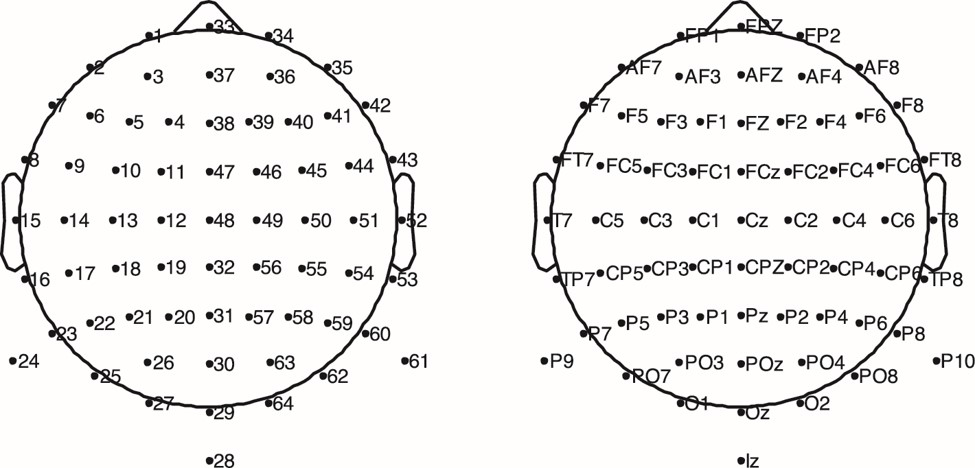

In [11]:
from IPython.display import Image
Image('dataset_hand_MI_bin/location_of_sensors.jpg', width=600, height=300)

Рассмотрим 52 испытуемого и его записи EEG, соотвествующие нулевому классу. Нумерация датчиков на графиках реализована в соответствие с рисунком выше, на вход подается номер датчика на единицу меньше.

In [13]:
sub_analysis = correlation_analysis('dataset_hand_MI_bin/s10.pkl', 'imagery_left')

Номер ближайшего датчика: 23, расстояние: 3.954
Номер самого удаленного датчика: 35, расстояние: 18.591


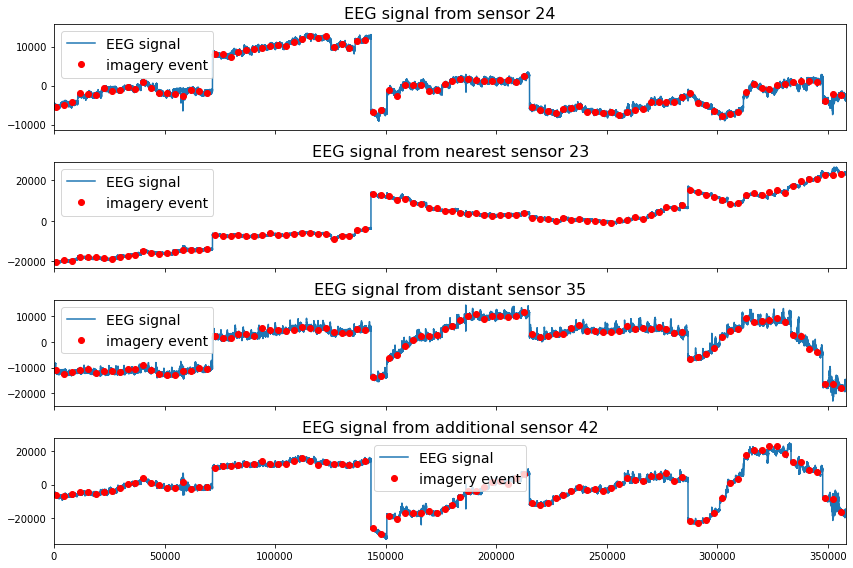

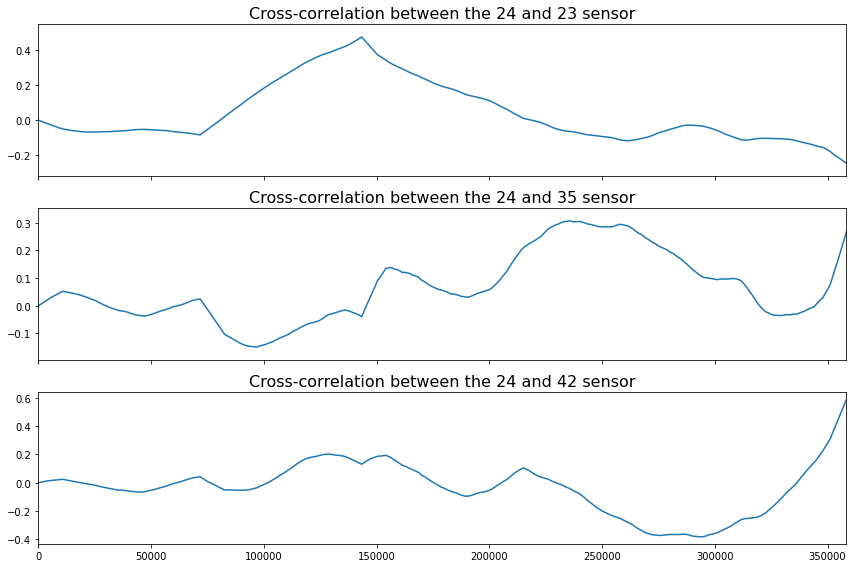

In [24]:
sub_analysis.plot_signals_and_corrs(23, 41)

Отрисуем heatmap

In [54]:
data = load_object('dataset_hand_MI_bin/s51.pkl')
# Данные ЭЭГ испытуемого
ts = np.array(data['eeg']['imagery_right'])[:64]

In [55]:
df = pd.DataFrame(ts.T, columns=[f'sensor_{i+1}' for i in range(ts.T.shape[1])])

<Axes: >

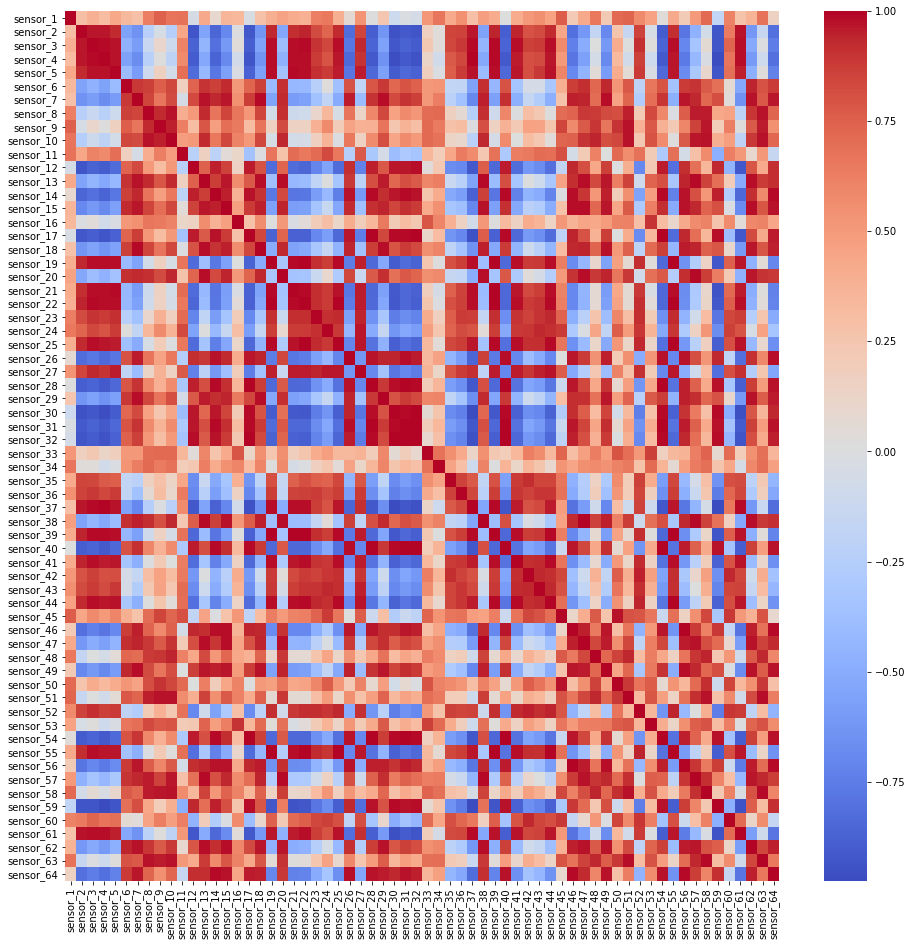

In [56]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(method='pearson'), cmap='coolwarm')
#annot = True, fmt='.2g'

---

## Сравнение EEG сигналов во время воображаемого движения руки и реального

Рассмотрим первого испытуемого и данные ЭЭГ его реальных и воображаемых движений левой руки. Зона мозга, отвечающая за двигательные операции человека называется моторная кора. В области моторной коры при измерениях с помощью электроэнцефалографии (ЭЭГ) обычно устанавливают центральные датчики, обозначаемые как C3 и C4. Эти датчики располагаются над соответствующими областями мозга, ответственными за движения рук и других частей тела. Рассмотрим сигналы с C3, который является 13-ым по рисунку выше

In [8]:
data = load_object('dataset_hand_MI_bin/s52.pkl')

# Данные ЭЭГ при воображаемом движении и реальном движении
ts_imagery = np.array(data['eeg']['imagery_left'])[12][:10000]
ts = np.array(data['eeg']['movement_left'])[12][:10000]
# Центрированные временные ряды
ts_imagery_centered = ts_imagery - ts_imagery.mean(keepdims=True)
ts_centered = ts - ts.mean(keepdims=True)

In [9]:
imagery_event = np.array(data['eeg']['imagery_event'])[:10000]
# Индексы моментов воображения действия объектом
imagery_event_indexes = np.array([i for i in range(len(imagery_event)) if imagery_event[i] == 1])

movement_event = np.array(data['eeg']['movement_event'])[:10000]
movement_event_indexes = np.array([i for i in range(len(movement_event)) if movement_event[i] == 1])

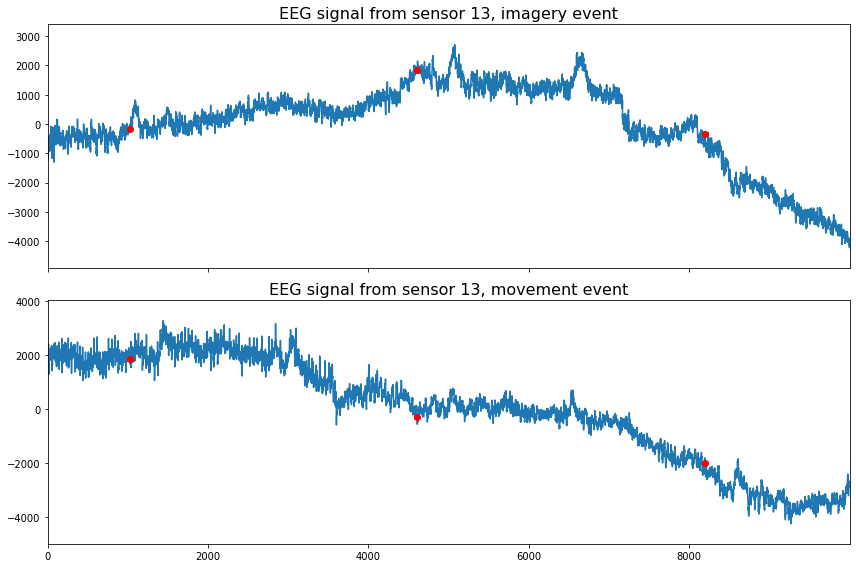

In [10]:
fig, (ax_ts_imagery, ax_ts) = plt.subplots(2, 1, sharex=True, layout='constrained')
ax_ts_imagery.plot(ts_imagery_centered)
ax_ts_imagery.plot(imagery_event_indexes, ts_imagery_centered[imagery_event_indexes], 'ro')
ax_ts_imagery.set_title('EEG signal from sensor 13, imagery event', fontsize = '16')
ax_ts.plot(ts_centered)
ax_ts.plot(movement_event_indexes, ts_centered[movement_event_indexes], 'ro')
ax_ts.set_title('EEG signal from sensor 13, movement event', fontsize = '16')
ax_ts_imagery.margins(0, 0.1)
ax_ts.margins(0, 0.1)
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Cross-correlation between real and imegery movement signal')

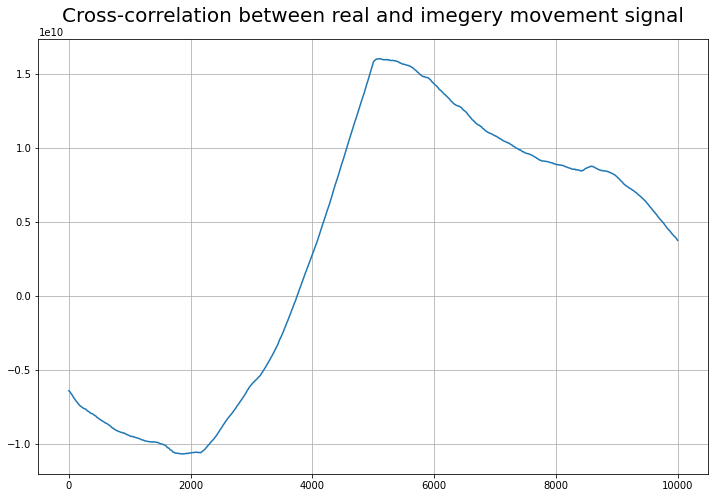

In [11]:
corr = correlate(ts_imagery_centered, ts_centered, 'same')

plt.figure(figsize = (12,8))

plt.plot(corr)
plt.grid(0.1)
plt.title('Cross-correlation between real and imegery movement signal', fontsize= 20)

---

### DTW

In [26]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [52]:
data = load_object('dataset_hand_MI_bin/s52.pkl')
ts = np.array(data['eeg']['imagery_left'])[:64]

In [58]:
ts_ = ts[:,:3584]
ts_centered = ts_ - ts_.mean(axis=1, keepdims=True)

In [59]:
ts_centered.shape

(64, 3584)

In [60]:
ts1 = ts_centered[12]
ts2 = ts_centered[49]

In [12]:
#path = dtw.warping_path(ts1, ts2)
#dtwvis.plot_warping(ts1, ts2, path, filename="warp.png")
dtw.distance(ts1, ts2)